# Homework 1

## FINM 36700 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

## HBS Case

### *The Harvard Management Company and Inflation-Indexed Bonds*

### Notation
(Hidden LaTeX commands)

$$\newcommand{\mux}{\tilde{\boldsymbol{\mu}}}$$
$$\newcommand{\wtan}{\boldsymbol{\text{w}}^{\text{tan}}}$$
$$\newcommand{\wtarg}{\boldsymbol{\text{w}}^{\text{port}}}$$
$$\newcommand{\mutarg}{\tilde{\boldsymbol{\mu}}^{\text{port}}}$$
$$\newcommand{\wEW}{\boldsymbol{\text{w}}^{\text{EW}}}$$
$$\newcommand{\wRP}{\boldsymbol{\text{w}}^{\text{RP}}}$$
$$\newcommand{\wREG}{\boldsymbol{\text{w}}^{\text{REG}}}$$

***

# 1. HMC's Approach

**Section 1 is not graded**, and you do not need to submit your answers. But you are encouraged to think about them, and we will discuss them.

### 1. 
There are thousands of individual risky assets in which HMC can invest.  Explain why MV optimization across 1,000 securities is infeasible.

### 2.
Rather than optimize across all securities directly, HMC runs a two-stage optimization.
1. They build asset class portfolios with each one optimized over the securities of the specific asset class.  
2. HMC combines the asset-class portfolios into one total optimized portfolio.

In order for the two-stage optimization to be a good approximation of the full MV-optimization on all assets, what must be true of the partition of securities into asset classes?

### 3.
Should TIPS form a new asset class or be grouped into one of the other 11 classes?

### 4. 
Why does HMC focus on real returns when analyzing its portfolio allocation? Is this just a matter of scaling, or does using real returns versus nominal returns potentially change the MV solution?

### 5.
The case discusses the fact that Harvard places bounds on the portfolio allocation rather than implementing whatever numbers come out of the MV optimization problem.

How might we adjust the stated optimization problem in the lecture notes to reflect the extra constraints Harvard is using in their bounded solutions given in Exhibits 5 and 6. Just consider how we might rewrite the optimization; don’t try to solve this extra-constrained optimization.

### 6. 
Exhibits 5 shows zero allocation to domestic equities and domestic bonds across the entire computed range of targeted returns, (5.75% to 7.25%). Conceptually, why is the constraint binding in all these cases? What would the unconstrained portfolio want to do with those allocations and why?

### 7.
Exhibit 6 changes the constraints, (tightening them in most cases.) How much deterioration do we see in the mean-variance tradeoff that Harvard achieved?

***

# 2 Mean-Variance Optimization

<i>This section is graded for a good-faith effort by your group. Submit your write-up- along with your supporting code. 
    
    Don't just submit code or messy numbers; submit a coherent write-up based on your work.</i>

### Data
You will need the file in the github repo, `data/multi_asset_etf_data.xlsx`.
- The time-series data gives monthly returns for the 11 asset classes and a short-term Treasury-bill fund return, ("SHV",) which we consider as the risk-free rate.
- The data is provided in total returns, (in which case you should ignore the SHV column,) as well as excess returns, (where SHV has been subtracted from the other columns.)
- These are nominal returns-they are not adjusted for inflation, and in our calculations we are not making any adjustment for inflation.
- The exhibit data that comes via Harvard with the case is unnecessary for our analysis.

### Model
We are going to analyze the problem in terms of **excess** returns.
- Thus, you will focus on the `Excess Returns` section of the lecture notes, especially the formulas on slide 50.
- Be sure to use the`excess returns` tab of the data.

### Format
In the questions below, **annualize the statistics** you report.
- Annualize the mean of monthly returns with a scaling of 12.
- Annualize the volatility of monthly returns with a scaling of $\sqrt{12}$
- The Sharpe Ratio is the mean return divided by the volatility of returns. Accordingly, we can annualize the Sharpe Ratio with a scaling of $\sqrt{12}$
- Note that we are not scaling the raw timeseries data, just the statistics computed from it (mean, vol, Sharpe). 

Importing Packages

In [1]:
import pandas as pd
import numpy as np
pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

Import data from excess returns tab of excel

In [2]:
multi_asset_etf_excess_ret = pd.read_excel('..\data\multi_asset_etf_data.xlsx', sheet_name = 'excess returns').set_index('Date')
multi_asset_etf_excess_ret.head(5)

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
Date,,,,,,,,,,,
2009-04-30,0.0084,-0.0016,0.1550,0.1146,0.1379,-0.0280,0.2956,0.2296,0.0223,0.0988,-0.0185
2009-05-31,0.0541,0.1631,0.1599,0.1324,0.0290,-0.0203,0.0232,0.0544,0.0283,0.0589,0.0204
2009-06-30,0.0045,-0.0269,-0.0231,-0.0146,0.0329,-0.0062,-0.0255,0.0414,-0.0040,-0.0013,0.0014
2009-07-31,0.0313,0.0186,0.1102,0.1004,0.0692,0.0083,0.1058,0.1433,0.0154,0.0746,0.0009
2009-08-31,0.0072,-0.0408,-0.0136,0.0446,-0.0174,0.0072,0.1315,0.0330,-0.0046,0.0365,0.0080


In [3]:
multi_asset_etf_excess_ret.dtypes

BWX    float64
DBC    float64
EEM    float64
EFA    float64
HYG    float64
IEF    float64
IYR    float64
PSP    float64
QAI    float64
SPY    float64
TIP    float64
dtype: object

Create helper function to find annualized summary statistics

In [4]:
def summary_statistics_annualized(returns, annual_factor = 12):
    #This function returns the summary statistics for the input total/excess returns passed in

    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean() * annual_factor
    summary_statistics['Vol'] = returns.std() * np.sqrt(annual_factor)
    summary_statistics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annual_factor)
    summary_statistics['Min'] = returns.min()
    summary_statistics['Max'] = returns.max()
    summary_statistics['Skewness'] = returns.skew()
    summary_statistics['Excess Kurtosis'] = returns.kurtosis()
    summary_statistics['Var (0.05)'] = returns.quantile(.05,axis = 0)
    summary_statistics['CVaR (0.05)'] = returns[returns <= returns.quantile(.05, axis = 0)].mean()

    return summary_statistics

### Footnotes

#### Data File
* The case does not give time-series data, so this data has been compiled outside of the case, and it intends to represent the main asset classes under consideration via various ETFs. For details on the specific securities/indexes, check the “Info” tab of the data.

#### Risk-free rate
* In the lecture-note we considered a constant risk-free rate. It is okay that our risk-free rate changes over time, but the assumption is that investors know it’s value one-period ahead of time. Thus, at any given point in time, it is a risk-free rate for the next period. (This is often discussed as the "bank account" or "money market account" in other settings.

## 1. Summary Statistics
* Calculate and display the mean and volatility of each asset’s excess return. (Recall we use volatility to refer to standard deviation.)
* Which assets have the best and worst Sharpe ratios? Recall that the Sharpe Ratio is simply the ratio of the mean-to-volatility of excess returns:
$$\text{sharpe ratio of investment }i = \frac{\mux_i}{\sigma_i}$$

## 2. Descriptive Analysis
* Calculate the correlation matrix of the returns. Which pair has the highest correlation? And the lowest?
* How well have TIPS done in our sample? Have they outperformed domestic bonds? Foreign bonds?

## 3. The MV frontier.
* Compute and display the weights of the tangency portfolios: $\wtan$.
* Does the ranking of weights align with the ranking of Sharpe ratios?
* Compute the mean, volatility, and Sharpe ratio for the tangency portfolio corresponding to
$\wtan$.

## 4. TIPS
Assess how much the tangency portfolio (and performance) change if...
* TIPS are dropped completely from the investment set.
* The expected excess return to TIPS is adjusted to be 0.0012 higher than what the historic sample shows.

Based on the analysis, do TIPS seem to expand the investment opportunity set, implying that Harvard should consider them as a separate asset?

Question 1

In [36]:
sum_stats_label = summary_statistics_annualized(multi_asset_etf_excess_ret)
sum_stats = summary_statistics_annualized(multi_asset_etf_excess_ret).sort_values( 'Sharpe', ascending=False)
sum_stats

,Mean,Vol,Sharpe,Min,Max,Skewness,Excess Kurtosis,Var (0.05),CVaR (0.05)
SPY,0.1437,0.1477,0.9732,-0.1290,0.1268,-0.3868,0.6016,-0.0675,-0.0869
HYG,0.0642,0.0892,0.7197,-0.1044,0.1379,0.4607,5.7623,-0.0287,-0.0512
IYR,0.1295,0.1871,0.6920,-0.2005,0.2956,0.4899,4.7454,-0.0650,-0.0972
EFA,0.0816,0.1660,0.4916,-0.1452,0.1429,-0.0658,0.7240,-0.0765,-0.1008
TIP,0.0224,0.0517,0.4332,-0.0678,0.0423,-0.6380,2.5229,-0.0204,-0.0330
QAI,0.0190,0.0508,0.3734,-0.0605,0.0364,-0.5567,1.7665,-0.0196,-0.0342
PSP,0.0799,0.2274,0.3516,-0.2951,0.2296,-0.4402,2.6579,-0.1030,-0.1465
EEM,0.0649,0.1965,0.3302,-0.1791,0.1628,0.1369,0.8588,-0.0817,-0.1128
IEF,0.0143,0.0624,0.2287,-0.0476,0.0461,-0.0875,0.1744,-0.0292,-0.0396
DBC,0.0254,0.1790,0.1422,-0.1776,0.1631,-0.3254,0.6971,-0.0859,-0.1150


The 3 assets with the best sharpe ratios are SPY, HYG, and IYR. The 3 assets with the lowest sharpe ratio are IEF, DBC, and BWX.

Question 2

       BWX     DBC     EEM     EFA     HYG     IEF    IYR     PSP    QAI  \
BWX 1.0000  0.3498  0.6476  0.6217  0.5577  0.4345 0.4535  0.5249 0.6680   
DBC 0.3498  1.0000  0.5657  0.5819  0.4732 -0.3217 0.3183  0.4961 0.5479   
EEM 0.6476  0.5657  1.0000  0.8516  0.7260 -0.1023 0.6218  0.7717 0.8072   
EFA 0.6217  0.5819  0.8516  1.0000  0.7715 -0.1323 0.6979  0.8919 0.8537   
HYG 0.5577  0.4732  0.7260  0.7715  1.0000 -0.0086 0.7576  0.8238 0.7688   
IEF 0.4345 -0.3217 -0.1023 -0.1323 -0.0086  1.0000 0.0736 -0.1187 0.0557   
IYR 0.4535  0.3183  0.6218  0.6979  0.7576  0.0736 1.0000  0.7602 0.6560   
PSP 0.5249  0.4961  0.7717  0.8919  0.8238 -0.1187 0.7602  1.0000 0.8383   
QAI 0.6680  0.5479  0.8072  0.8537  0.7688  0.0557 0.6560  0.8383 1.0000   
SPY 0.4657  0.5099  0.7346  0.8716  0.7704 -0.1557 0.7536  0.8957 0.8410   
TIP 0.6171  0.1367  0.3027  0.2875  0.3659  0.7061 0.3972  0.3209 0.4597   

        SPY    TIP  
BWX  0.4657 0.6171  
DBC  0.5099 0.1367  
EEM  0.7346 0.3027  
EFA

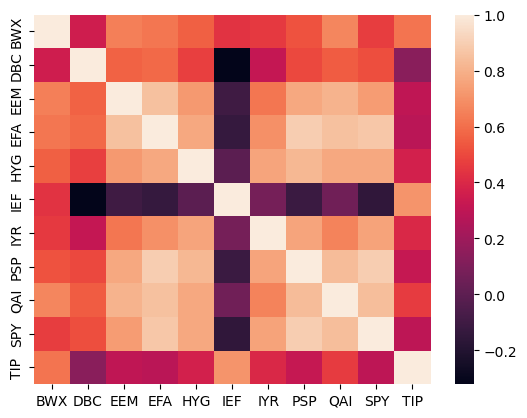

In [6]:
corr_matrix = multi_asset_etf_excess_ret.corr()
sns.heatmap(corr_matrix)
print(corr_matrix)

The security pair with the highest correlation is PSP and SPY with a correlation of .8957. The pair with the lowest correlation is IEF and DCB with a correlation of -0.3217.

TIPs have done fairly well in our sample ranking 5th in terms of Sharpe ratio. TIPs have outperformed both domestic and international bonds.

Question 3

Create function for Tangency weights

In [7]:
def tangency_weights(asset_return,cov_matrix, cov_diagnolize = False):
    """ 
        Returns the tangency portfolio weights in a (1 x n) vector
        Inputs: 
            asset_return - return for each asset (n x 1) Vector
            cov_matrix = nxn covariance matrix for the assets
    """
    if cov_diagnolize:
        asset_cov = np.diag(np.diag(cov_matrix))
    else:
        asset_cov = np.array(cov_matrix)
    inverted_cov= np.linalg.inv(asset_cov)
    one_vector = np.ones(len(cov_matrix.index))
    
    den = (one_vector @ inverted_cov) @ (asset_return)
    num =  inverted_cov @ asset_return
    return (1/den) * num

In [8]:
mean_excess_return = np.array(sum_stats['Mean'])

In [21]:
print(multi_asset_etf_excess_ret.cov())
print(mean_excess_return/12)

       BWX     DBC     EEM     EFA     HYG     IEF    IYR     PSP    QAI  \
BWX 0.0006  0.0004  0.0009  0.0007  0.0003  0.0002 0.0006  0.0008 0.0002   
DBC 0.0004  0.0027  0.0017  0.0014  0.0006 -0.0003 0.0009  0.0017 0.0004   
EEM 0.0009  0.0017  0.0032  0.0023  0.0011 -0.0001 0.0019  0.0029 0.0007   
EFA 0.0007  0.0014  0.0023  0.0023  0.0010 -0.0001 0.0018  0.0028 0.0006   
HYG 0.0003  0.0006  0.0011  0.0010  0.0007 -0.0000 0.0011  0.0014 0.0003   
IEF 0.0002 -0.0003 -0.0001 -0.0001 -0.0000  0.0003 0.0001 -0.0001 0.0000   
IYR 0.0006  0.0009  0.0019  0.0018  0.0011  0.0001 0.0029  0.0027 0.0005   
PSP 0.0008  0.0017  0.0029  0.0028  0.0014 -0.0001 0.0027  0.0043 0.0008   
QAI 0.0002  0.0004  0.0007  0.0006  0.0003  0.0000 0.0005  0.0008 0.0002   
SPY 0.0005  0.0011  0.0018  0.0018  0.0008 -0.0001 0.0017  0.0025 0.0005   
TIP 0.0002  0.0001  0.0003  0.0002  0.0001  0.0002 0.0003  0.0003 0.0001   

        SPY    TIP  
BWX  0.0005 0.0002  
DBC  0.0011 0.0001  
EEM  0.0018 0.0003  
EFA

In [37]:
tangent_port = tangency_weights(multi_asset_etf_excess_ret.mean(),multi_asset_etf_excess_ret.cov())
tangentPort_df = pd.DataFrame(tangent_port, columns=["Tangent Portfolio Weights"], index=sum_stats_label.index).sort_values('Tangent Portfolio Weights', ascending=False)
tangentPort_df

,Tangent Portfolio Weights
SPY,2.5922
IEF,1.8956
HYG,1.5303
EFA,0.4533
TIP,0.3564
EEM,0.2613
DBC,0.0285
IYR,-0.2430
PSP,-1.2721
BWX,-1.4662


In [27]:
sum_stats['Sharpe']

SPY    0.9732
HYG    0.7197
IYR    0.6920
EFA    0.4916
TIP    0.4332
QAI    0.3734
PSP    0.3516
EEM    0.3302
IEF    0.2287
DBC    0.1422
BWX   -0.0221
Name: Sharpe, dtype: float64

The ranking of the portfolio weights does not align with the ranking of the Sharpe Ratios.

Function to find portfolio stats

In [39]:
def mvo_performance_stats(asset_returns,cov_matrix,port_weights, port_type,period):
    """ 
        Returns the Annualized Performance Stats for given asset returns, portfolio weights and covariance matrix
        Inputs: 
            asset_return - Excess return over the risk free rate for each asset (n x 1) Vector
            cov_matrix = nxn covariance matrix for the assets
            port_weights = weights of the assets in the portfolio (1 x n) Vector
            port_type = Type of Portfolio | Eg - Tangency or Mean-Variance Portfolio
            period = Monthly frequency
    """
    
    ret = np.dot(port_weights,asset_returns)*period
    vol = np.sqrt(port_weights @ cov_matrix @ port_weights.T)*np.sqrt(period)
    sharpe = ret/vol

    stats = pd.DataFrame([[ret,vol,sharpe]],columns= ["Annualized Return","Annualized Volatility","Annualized Sharpe Ratio"], index = [port_type])
    return stats

In [40]:
tangent_port_stats = mvo_performance_stats(multi_asset_etf_excess_ret.mean(), multi_asset_etf_excess_ret.cov(), tangent_port, 'Tangent Portfolio',12)
tangent_port_stats

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Tangent Portfolio,0.3705,0.1917,1.9328


Question 4

Tangent Portfolio Without TIPs

In [41]:
multi_asset_etf_excess_ret.head(5)

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
Date,,,,,,,,,,,
2009-04-30,0.0084,-0.0016,0.1550,0.1146,0.1379,-0.0280,0.2956,0.2296,0.0223,0.0988,-0.0185
2009-05-31,0.0541,0.1631,0.1599,0.1324,0.0290,-0.0203,0.0232,0.0544,0.0283,0.0589,0.0205
2009-06-30,0.0045,-0.0269,-0.0231,-0.0146,0.0329,-0.0062,-0.0255,0.0414,-0.0040,-0.0013,0.0014
2009-07-31,0.0313,0.0186,0.1102,0.1004,0.0692,0.0083,0.1058,0.1433,0.0154,0.0746,0.0009
2009-08-31,0.0072,-0.0408,-0.0136,0.0446,-0.0174,0.0072,0.1315,0.0330,-0.0046,0.0365,0.0080


In [42]:
returns_minus_tips = multi_asset_etf_excess_ret.drop(columns=['TIP'])
sum_stats_minus_tips = summary_statistics_annualized(returns_minus_tips)
returns_minus_tips.head(5)

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY
Date,,,,,,,,,,
2009-04-30,0.0084,-0.0016,0.1550,0.1146,0.1379,-0.0280,0.2956,0.2296,0.0223,0.0988
2009-05-31,0.0541,0.1631,0.1599,0.1324,0.0290,-0.0203,0.0232,0.0544,0.0283,0.0589
2009-06-30,0.0045,-0.0269,-0.0231,-0.0146,0.0329,-0.0062,-0.0255,0.0414,-0.0040,-0.0013
2009-07-31,0.0313,0.0186,0.1102,0.1004,0.0692,0.0083,0.1058,0.1433,0.0154,0.0746
2009-08-31,0.0072,-0.0408,-0.0136,0.0446,-0.0174,0.0072,0.1315,0.0330,-0.0046,0.0365


In [43]:
tangent_port_minus_tips = tangency_weights(returns_minus_tips.mean(),returns_minus_tips.cov())
tangentPort_minus_tips_df = pd.DataFrame(tangent_port_minus_tips, columns=["Tangent Portfolio Weights"], index=sum_stats_minus_tips.index).sort_values('Tangent Portfolio Weights', ascending=False)
tangentPort_minus_tips_df

,Tangent Portfolio Weights
SPY,2.7314
IEF,2.2125
HYG,1.5931
EFA,0.4415
EEM,0.2781
DBC,0.0552
IYR,-0.2459
PSP,-1.3141
BWX,-1.5127
QAI,-3.2390


In [44]:
tangent_port_minus_tips_stats = mvo_performance_stats(returns_minus_tips.mean(), returns_minus_tips.cov(), tangent_port_minus_tips, 'Tangent Portfolio Without TIPs',12)
tangent_port_minus_tips_stats

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Tangent Portfolio Without TIPs,0.3863,0.2001,1.9304


Tangent Portfolio with TIPs adjusted by .0012

In [48]:
adjusted_tips_mean = multi_asset_etf_excess_ret
adjusted_tips_df['TIP'] = adjusted_tips_df['TIP'] + .0012
sum_stats_adjusted_tips = summary_statistics_annualized(adjusted_tips_df)
adjusted_tips_df.head(5)

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
Date,,,,,,,,,,,
2009-04-30,0.0084,-0.0016,0.1550,0.1146,0.1379,-0.0280,0.2956,0.2296,0.0223,0.0988,-0.0174
2009-05-31,0.0541,0.1631,0.1599,0.1324,0.0290,-0.0203,0.0232,0.0544,0.0283,0.0589,0.0217
2009-06-30,0.0045,-0.0269,-0.0231,-0.0146,0.0329,-0.0062,-0.0255,0.0414,-0.0040,-0.0013,0.0026
2009-07-31,0.0313,0.0186,0.1102,0.1004,0.0692,0.0083,0.1058,0.1433,0.0154,0.0746,0.0021
2009-08-31,0.0072,-0.0408,-0.0136,0.0446,-0.0174,0.0072,0.1315,0.0330,-0.0046,0.0365,0.0092


In [49]:
tangent_port_adjusted_tips = tangency_weights(adjusted_tips_df.mean(),adjusted_tips_df.cov())
tangentPort_adjusted_tips_df = pd.DataFrame(tangent_port_adjusted_tips, columns=["Tangent Portfolio Weights"], index=sum_stats_adjusted_tips.index).sort_values('Tangent Portfolio Weights', ascending=False)
tangentPort_adjusted_tips_df

,Tangent Portfolio Weights
SPY,2.0071
TIP,1.8684
HYG,1.2666
IEF,0.5544
EFA,0.5045
EEM,0.1903
DBC,-0.0848
IYR,-0.2311
PSP,-1.0969
BWX,-1.2720


In [51]:
tangent_port_adjusted_tips_stats = mvo_performance_stats(adjusted_tips_df.mean(), adjusted_tips_df.cov(), tangent_port_adjusted_tips, 'Tangent Portfolio With Adjusted TIPs',12)
tangent_port_adjusted_tips_stats

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Tangent Portfolio With Adjusted TIPs,0.3312,0.1631,2.0304


In [56]:
tangent_port_minus_tips_stats

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Tangent Portfolio Without TIPs,0.3863,0.2001,1.9304


In [55]:
tangent_port_stats

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Tangent Portfolio,0.3705,0.1917,1.9328


Based on the Sharpe Ratios TIPs should be included in the portfolio.

***

# 3. Allocations

<i>This section is graded for a good-faith effort by your group. Submit your write-up- along with your supporting code.

* Continue with the same data file as the previous section.

* Suppose the investor has a targeted mean excess return (per month) of $\mutarg$ = 0.01.

Build the following portfolios:

#### Equally-weighted (EW)
Rescale the entire weighting vector to have target mean $\mutarg$. Thus, the $i$ element of the weight vector is,
$$\wEW_i = \frac{1}{n}$$

#### “Risk-parity” (RP)
Risk-parity is a term used in a variety of ways, but here we have in mind setting the weight of the portfolio to be proportional to the inverse of its full-sample variance estimate. Thus, the $i$ element of the weight vector is,
$$\wRP_i = \frac{1}{\sigma_i^2}$$

#### Regularized (REG)
Much like the Mean-Variance portfolio, set the weights proportional to 
$$\wREG \sim \widehat{\Sigma}^{-1}\mux$$
but this time, use a regularized covariance matrix,
$$\widehat{\Sigma} = \frac{\Sigma + \Sigma_D}{2}$$
where $\Sigma_D$ denotes a *diagonal* matrix of the security variances, with zeros in the off-diagonals.

Thus, $\widehat{\Sigma}$ is obtained from the usual covariance matrix, $\Sigma$, but shrinking all the covariances to half their estimated values. 


### Comparing

In order to compare all these allocation methods, (those above, along with the tangency portfolio obtained in the previous section,) rescale each weight vector, such that it has targeted mean return of $\mutarg$.

* Calculate the performance of each of these portfolios over the sample.
* Report their mean, volatility, and Sharpe ratio. 
* How do these compare across the four allocation methods?

In [58]:
target_return = 0.01
excess_return_mean = multi_asset_etf_excess_ret.mean()

Equally Weighted (EW)

In [82]:

equalWt = np.array(len(corr_matrix.index) * [1/len(corr_matrix.index)])
eql_rescale_factor = target_return/(equalWt.T @ excess_return_mean)

equalWt_port_stats = mvo_performance_stats(excess_return_mean, multi_asset_etf_excess_ret.cov(),(equalWt * eql_rescale_factor),'Equal Weight Portfolio',12)
equalWt_port_stats

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Equal Weight Portfolio,0.1200,0.2086,0.5753


In [63]:
equalWt

array([0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909])

Risk-Parity (RP)

In [83]:
stats = summary_statistics_annualized(multi_asset_etf_excess_ret)
rp_wt = np.array(1/stats['Vol'])
rp_rescale_factor = target_return/ (rp_wt.T @ excess_return_mean)

risk_parity_stats = mvo_performance_stats(excess_return_mean,multi_asset_etf_excess_ret.cov(),(rp_wt * rp_rescale_factor),'Risk Parity Portfolio',12)
risk_parity_stats

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Risk Parity Portfolio,0.1200,0.1963,0.6112


Regularized (REG)

In [84]:
asset_var = multi_asset_etf_excess_ret.var()
reg_cov_matrix = (multi_asset_etf_excess_ret.cov() + np.diag(asset_var))/2
reg_wt = np.linalg.inv(reg_cov_matrix).dot(np.array(excess_return_mean))
reg_rescale = .12/1.7842

regularized_stats = mvo_performance_stats(excess_return_mean, multi_asset_etf_excess_ret.cov(),(reg_wt*reg_rescale),'Regularized Portfolio',12)
regularized_stats

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Regularized Portfolio,0.1200,0.0868,1.3826


In [76]:
np.array(excess_return_mean)

array([-0.0001536 ,  0.00212029,  0.00540727,  0.00679974,  0.00534736,
        0.00118909,  0.01078944,  0.00666152,  0.0015812 ,  0.01197729,
        0.00306677])

***

# 4. Out-of-Sample Performance

<i>This section is not graded, and you do not need to submit it. Still, we may discuss it in class, in which case, you would be expected to know it.

## 1. One-step Out-of-Sample (OOS) Performance
Let’s divide the sample to both compute a portfolio and then check its performance out of sample.
* Using only data through the end of 2021, compute the weights built in Section 3.
* Rescale the weights, (using just the in-sample data,) to set each allocation to have the same mean return of $\mutarg$.
* Using those weights, calculate the portfolio’s Sharpe ratio within that sample.
* Again using those weights, (derived using data through 2021,) calculate the portfolio’s OOS Sharpe ratio, which is based only on performance in 2022-2023.

## 2. Rolling OOS Performance

Iterate the Out-of-Sample performance every year, not just the final year. Namely,
* Start at the end of 2014, and calculate the weights through that time. Rescale them using the mean returns through that time.
* Apply the weights to the returns in the upcoming year, (2015.)
* Step forward a year in time, and recompute.
* Continue until again calculating the weights through 2022 and applying them to the returns in 2023.

Report the mean, volatility, and Sharpe from this dynamic approach for the following portfolios:
* mean-variance (tangency)
* equally-weighted
* risk-parity
* regularized

***

# 5. Without a Riskless Asset

<i>This section is not graded, and you do not need to submit it. Still, we may discuss it in class, in which case, you would be expected to know it.

Re-do Section 2 above, but in the model without a risk-free rate.

That is, build the MV allocation using the two-part formula in the `Mean-Variance` section of the notes.
* This essentially substitutes the risk-free rate with the minimum-variance portfolio.
* Now, the allocation depends nonlinearly on the target mean return, $\mutarg$. (With a risk-free rate, we simply scale the weights up and down to achieve the mean return.)

You will find that, conceptually, the answers are very similar. 

***